In [76]:
import re
import random
import pandas as pd
import hashlib

In [77]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [78]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Linux,125.796489,3.931140,15.606978,32
GUI Docker Container,88.323701,4.205891,8.484075,21
"Everything is Tuberculosis, Green",104.768806,4.555165,15.216458,23
WinHex,168.566406,8.026972,12.237213,21
Azure Compute Gallery,39.878149,19.939075,21.333099,2
"The Simulacra, Dick",454.775880,23.935573,41.193173,19
Windows PATH Variable,914.868038,30.495601,86.167319,30
Node.JS and React,1418.711411,45.764884,123.801651,31
pfSense,253.314827,50.662965,101.029969,5
"Mexican Gothic, Moreno-Garcia",1610.818054,57.529216,213.350443,28


# Histogram

sum of ages: ~50859.33


<Axes: >

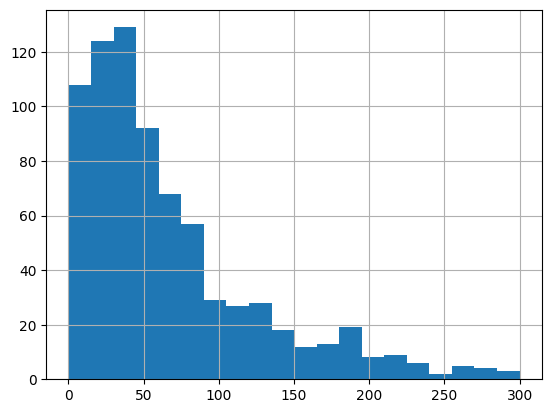

In [79]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~50859.33


<Axes: >

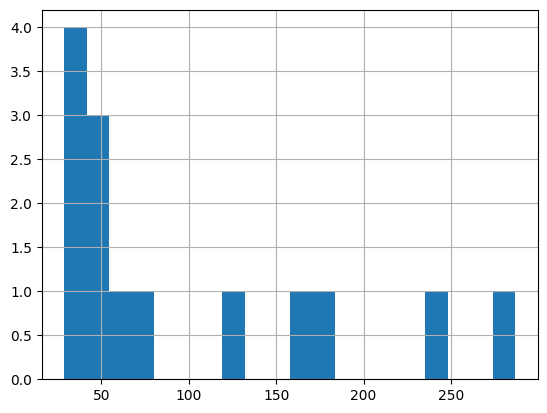

In [80]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Vocab']['age'].hist(bins=20)

# Completely Random Shuffle

In [81]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [82]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [83]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [84]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [85]:
n = random.choice([2, 3, 3, 4, 5])

existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 761
Total card age: 50859.33


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
21,Terraform Codebox,path.module in Terraform refers to the directo...,0077d1efc41777feb76ac15cfa44de56,299.972165,98.782233,-299.972165,3852.507077,0.559780,39,0,0,-299.972165
286,Terraform Codebox,TF_LOG=DEBUG is an environment variable that m...,eb9c36cb0f05a2fd3b6125a9e1fbbab7,276.917179,98.782233,-299.972165,3852.507077,0.559780,39,1,0,-276.917179
542,Terraform Codebox,Terraform allows you to target specific parts ...,93c4df9dde5484c019ce7758b6524728,265.737383,98.782233,-299.972165,3852.507077,0.559780,39,2,0,-265.737383
44,Active Directory and Azure Files,Kerberos Key (Storage Account key)\nA secret (...,7c008b725311d3b542f19e49340e719d,290.090182,90.823268,-290.090182,3269.637645,0.610293,36,0,0,-290.090182
309,Active Directory and Azure Files,Kerberos Ticket Granting Ticket (TGT)\nA Kerbe...,13cf1e8ae082b2829ba3da07db178be5,257.051711,90.823268,-290.090182,3269.637645,0.610293,36,1,0,-257.051711
563,Active Directory and Azure Files,Ticket Granting Service (TGS)\nThe Kerberos se...,8af197027d5a17cfe0ea020c1c71c7a2,203.646601,90.823268,-290.090182,3269.637645,0.610293,36,2,0,-203.646601
34,Vocab,"Jingo, Pratchett\nCruet\nnoun | KROO-it\nA sma...",528220646783dfd409ce4f2edf53a104,286.701383,99.443543,-286.701383,1392.209602,0.890370,14,0,0,-286.701383
299,Vocab,"Something Rotten, Fforde\nTimpet\nnoun | TIM-p...",cdaef1f8166f9351b220c1f851ffde58,237.561013,99.443543,-286.701383,1392.209602,0.890370,14,1,0,-237.561013
555,Vocab,"Jingo, Pratchett\nCornice\nnoun | KOR-nis\nA d...",c1d46a017602270a177566b05e8df19f,174.952776,99.443543,-286.701383,1392.209602,0.890370,14,2,0,-174.952776
8,Python + Oauth2.0,http.server.SimpleHTTPRequestHandler\n\nA buil...,142b6319783bfbbf45e56e053e9a4c0c,282.428916,104.119574,-282.428916,2186.511058,0.191359,21,0,0,-282.428916


## Card Count

In [86]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [87]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [88]:
existing_cards.head(10)['age'].sum()

np.float64(2575.0593077696576)

In [89]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
21,Terraform Codebox,path.module in Terraform refers to the directo...,0077d1efc41777feb76ac15cfa44de56,299.972165,98.782233,-299.972165,3852.507077,0.559780,39,0,0,-299.972165
44,Active Directory and Azure Files,Kerberos Key (Storage Account key)\nA secret (...,7c008b725311d3b542f19e49340e719d,290.090182,90.823268,-290.090182,3269.637645,0.610293,36,0,0,-290.090182
34,Vocab,"Jingo, Pratchett\nCruet\nnoun | KROO-it\nA sma...",528220646783dfd409ce4f2edf53a104,286.701383,99.443543,-286.701383,1392.209602,0.890370,14,0,0,-286.701383
8,Python + Oauth2.0,http.server.SimpleHTTPRequestHandler\n\nA buil...,142b6319783bfbbf45e56e053e9a4c0c,282.428916,104.119574,-282.428916,2186.511058,0.191359,21,0,0,-282.428916
273,Python + Oauth2.0,redirect_uri\n\nThe URL where the OAuth provid...,0f71673850ec4ac81e9d1d446c5f48a9,278.388282,104.119574,-282.428916,2186.511058,0.191359,21,1,0,-278.388282
286,Terraform Codebox,TF_LOG=DEBUG is an environment variable that m...,eb9c36cb0f05a2fd3b6125a9e1fbbab7,276.917179,98.782233,-299.972165,3852.507077,0.559780,39,1,0,-276.917179
87,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,276.490684,78.692979,-276.490684,3226.412159,0.577018,41,0,0,-276.490684
542,Terraform Codebox,Terraform allows you to target specific parts ...,93c4df9dde5484c019ce7758b6524728,265.737383,98.782233,-299.972165,3852.507077,0.559780,39,2,0,-265.737383
15,Asynchronous Python,return_exceptions=True (in gather)\nA paramete...,7b43de3dee4f46aa5adbf4020aff8165,264.727874,103.648496,-264.727874,1762.024437,0.842281,17,0,0,-264.727874
127,Azure Files Documentation,Quota is a limit on the size of the file share...,3bef1cf2ec625defd17ff26244de22f9,258.586849,73.524765,-258.586849,4190.911613,0.855709,57,0,0,-258.586849


In [90]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 66.832'